In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [33]:
DATASET_PATH = '/content/drive/MyDrive/grozny_hack_data/train_data_beeline/images'
MODEL_PATH = '/content/drive/MyDrive/grozny_hack_data/train_data_beeline/resnet18_letters.pth'
DETECT_MODEL_PATH = '/content/drive/MyDrive/grozny_hack_data/train_data_beeline/best_f_100.pt' ##веса модели, указанные в github

Вам предстоит создать алгоритм по деформации (выравниваню) автомобильных номеров и поместить его в функцию img_deformation.


! Вы не можете менять заданную OCR модель (дообучать тоже нельзя) и заданные шаблоны по разбиению изображения.

! Допустимы небольшие измениния трех основных .py файлов, если в этом есть необходимость для встраивания в ваши решения. Но их функционал должен быть сохранен.

# Файлы для работы с шаблонами

В разделе "Алогритм" показано что для чего нужно, так что имеет смысл сначала посетить его

## model.py

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18

label2letter = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
    10: "A", 11: "B", 12: "C", 13: "E", 14: "H", 15: "K", 16: "M", 17: "O", 18: "P", 19: "T", 20: "X", 21: "Y"
}

class LettersPrediction(object):
    def __init__(self):
        self.model = resnet18()
        self.model.fc = nn.Linear(self.model.fc.in_features, out_features=22)
        self.model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
        self.model.eval()

        self.imgsz = 64

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.imgsz, self.imgsz)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, img):
        input_tensor = self.transform(img)
        output_tensor = self.model(input_tensor.unsqueeze(0))
        predicted = torch.argmax(output_tensor)
        return label2letter[predicted.item()]

    def predict_series(self, imgs):
        s = ""
        for img in imgs:
            s += self.predict(img)
        return s

## template.py

Разбивает изображение на части по шаблонам

In [4]:
from pathlib import Path
import numpy as np

two_digit_region_template = [
    {'pos': 1, 'p1': (0.067, 0.250), 'p2': (0.177, 0.92)},
    {'pos': 2, 'p1': (0.19, 0.100), 'p2': (0.3, 0.92)},
    {'pos': 3, 'p1': (0.3, 0.100), 'p2': (0.41, 0.92)},
    {'pos': 4, 'p1': (0.41, 0.100), 'p2': (0.52, 0.92)},
    {'pos': 5, 'p1': (0.53, 0.250), 'p2': (0.64, 0.92)},
    {'pos': 6, 'p1': (0.64, 0.250), 'p2': (0.75, 0.92)},
    {'pos': 7, 'p1': (0.77, 0.05), 'p2': (0.86, 0.7)},
    {'pos': 8, 'p1': (0.86, 0.05), 'p2': (0.95, 0.7)}
]

three_digit_region_template = [
    {'pos': 1, 'p1': (0.05, 0.250), 'p2': (0.16, 0.92)},
    {'pos': 2, 'p1': (0.16, 0.100), 'p2': (0.27, 0.92)},
    {'pos': 3, 'p1': (0.265, 0.100), 'p2': (0.375, 0.92)},
    {'pos': 4, 'p1': (0.37, 0.100), 'p2': (0.48, 0.92)},
    {'pos': 5, 'p1': (0.475, 0.250), 'p2': (0.585, 0.92)},
    {'pos': 6, 'p1': (0.58, 0.250), 'p2': (0.69, 0.92)},
    {'pos': 7, 'p1': (0.71, 0.05), 'p2': (0.795, 0.7)},
    {'pos': 8, 'p1': (0.79, 0.05), 'p2': (0.875, 0.7)},
    {'pos': 9, 'p1': (0.87, 0.05), 'p2': (0.96, 0.7)}
]

def apply_template(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
       raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    crops = []
    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = sx * W, sy * H, ex * W, ey * H
        sx, sy, ex, ey = map(int, [sx, sy, ex, ey])
        crops.append(img[sy : ey, sx : ex])

    return crops


## Функция для деформации

Пропишите логику алгоритма по деформации внутри фунции img_deformation

In [5]:
##Установим библиотеку ultralytics для использования модели детекции
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.4/799.4 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [6]:
import cv2
import numpy as np
from ultralytics import YOLO

In [34]:
##определим модель
model_det = YOLO(DETECT_MODEL_PATH)

In [43]:
def normalized_coords(coords):
    ind1 = np.argmin(coords[:, 0])
    first = np.array(coords[ind1])
    coords = np.delete(coords, ind1, axis=0)
    ind2 = np.argmin(coords[:, 0])
    first = np.append(first, coords[ind2])
    first = first.reshape((2, 2))
    coords = np.delete(coords, ind2, axis=0)
    second = coords
    ind1 = np.argmin(first[:, 1])
    x1 = first[ind1]
    first = np.delete(first, ind1, axis=0)
    y1 = first[0]
    ind2 = np.argmin(second[:, 1])
    x2 = second[ind2]
    second = np.delete(second, ind2, axis=0)
    y2 = second[0]
    return x1, y1, x2, y2

In [35]:
def img_deformation(img):
  """ БЛОК АЛГОРИТМА ПО ДЕФОРМАЦИИ ИЗОБРАЖЕНИЯ """
  ##Получение координат углов таблички
  result = model_det(img, verbose=False)[0]
  boxes = result.obb.xyxyxyxy
  n_max_conf = [x for x in result.obb.conf.numpy()]
  if len(n_max_conf) > 0:
      n_max_conf = max(n_max_conf)
  else:
      n_max_conf = 0
  nms = list(map(lambda x: x == n_max_conf, result.obb.conf.numpy()))
  boxes = np.array(boxes[nms], np.int32)
  if (len(boxes) > 0):
    a, b, c, d = normalized_coords(boxes[0])
  else:
    a, b, c, d = [0, 0], [0, 112], [512, 0], [512, 112]
  pts1 = np.float32([a, b,
                     c, d])
  pts2 = np.float32([[0, 0], [0, 112],
                     [512, 0], [512, 112]])
  ##подсчет матрицы перспективы и последующее изменение перспективы номера при помощи координат углов
  matrix = cv2.getPerspectiveTransform(pts1, pts2)
  result = cv2.warpPerspective(img, matrix, (512, 112))
  # Преобразование изображения в оттенки серого
  gray_img = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

  # Преобразование одноканального изображения в трёхканальное
  result = cv2.merge([gray_img, gray_img, gray_img])


  """               КОНЕЦ БЛОКА                """
  return result

## predict.py

Выполняет предсказание для изображений разбитых по 2 и 3 шаблону

In [37]:
import argparse
from pathlib import Path
from tqdm import tqdm

import cv2
import pandas as pd
import os


#from template import apply_template
#from model import LettersPrediction

data_path = Path(DATASET_PATH)


regions_type = [2, 3]
model = LettersPrediction()


result = []

for p in tqdm(data_path.iterdir()):
    if not p.suffix in [".png", ".jpg", ".jpeg"]:
        continue
    result.append(
        {
            "image_name": p.stem,
            "prediction_region_length_2": "",
            "prediction_region_length_3": ""
        }
    )


    img = cv2.imread(str(p))

    #вызов фунции деформации
    img = img_deformation(img)
    ########################

    img = cv2.resize(img, (512,112))

    for region_type in regions_type:

        crops = apply_template(img, region_type)

        lp_number = model.predict_series(crops)
        result[-1][f"prediction_region_length_{region_type}"] = lp_number

pd.DataFrame(result).to_csv('modelPredict.csv', index=False)

0it [00:00, ?it/s]<ipython-input-35-10c46a0328c8>:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  boxes = np.array(boxes[nms], np.int32)
1039it [00:06, 167.53it/s]


# Алгоритм

![](https://sun9-2.userapi.com/impg/SfgCnkIYJeC_4clAh69dvC6ZwmBT9dLmMkh25A/DvScgey4ZCg.jpg?size=1916x1079&quality=96&sign=2ef5e9fadc1d8635c4963fb99affd07d&type=album)

In [12]:
import matplotlib.pyplot as plt
import os

#Рисует на изображение template
def draw_regions(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
        raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = int(sx * W), int(sy * H), int(ex * W), int(ey * H)
        cv2.rectangle(img, (sx, sy), (ex, ey), (0, 255, 0), 2)

    return img

#Визуализирует изображения из датасета
def draw(folder_path, show_template=False, template=2):

    file_list = os.listdir(folder_path)
    image_files = [f for f in file_list if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Устанавливаем количество изображений на строку
    images_per_row = 5

    num_rows = len(image_files) // images_per_row + int(len(image_files) % images_per_row != 0)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    for i in range(num_rows * images_per_row):
        if i < len(image_files):
            ax = axes.flat[i]
            img_path = os.path.join(folder_path, image_files[i])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if show_template:
              img = img_deformation(img)
              img = cv2.resize(img, (512,112))
              img_with_rectangles = draw_regions(img, template)

            ax.imshow(img)
            ax.axis('off')
            ax.set_title(os.path.basename(img_path))
        else:
            axes.flat[i].axis('off')

    plt.tight_layout()
    plt.show()


Визуализируем изображения из датасета

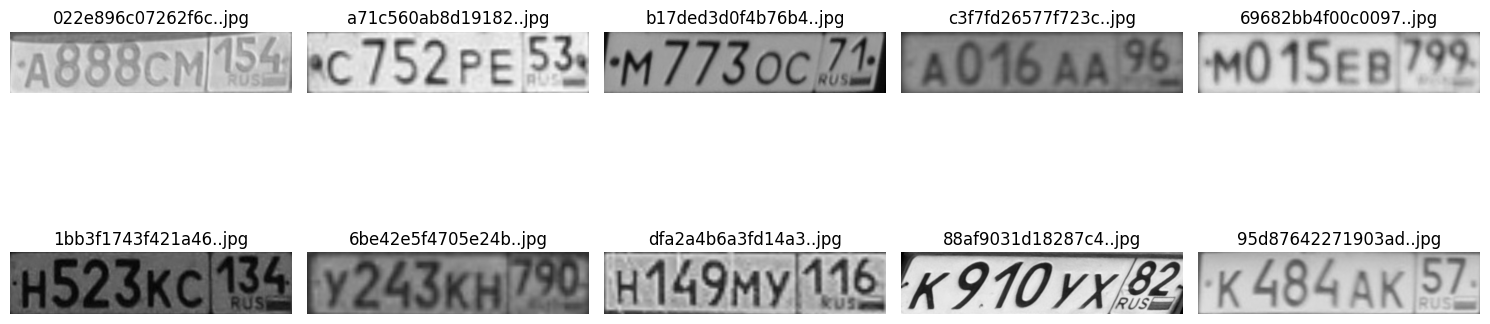

In [38]:
draw('/content/dimage', show_template=False)

Теперь визуализируем шаблон 2 для каждого изображения

<ipython-input-35-10c46a0328c8>:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  boxes = np.array(boxes[nms], np.int32)


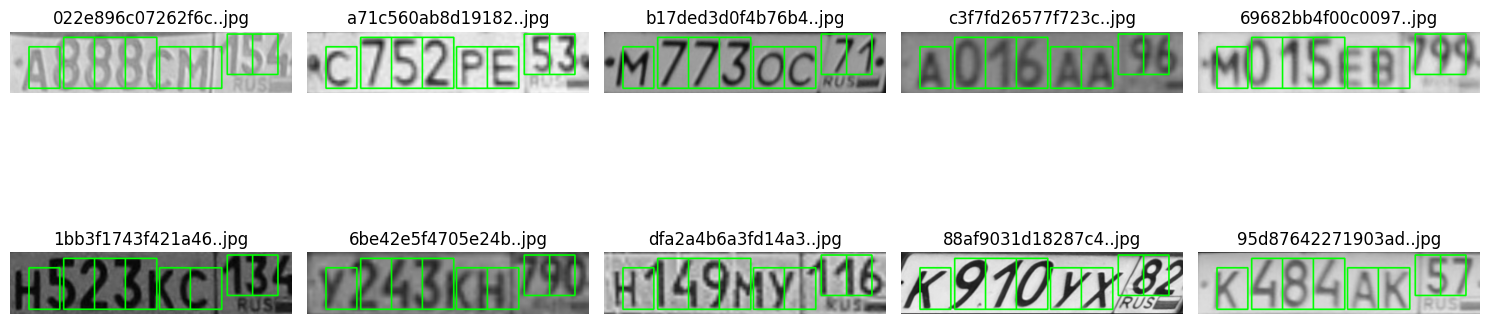

In [39]:
draw('/content/dimage', show_template=True)

Теперь визуализируем шаблон 3 для каждого изображения

<ipython-input-35-10c46a0328c8>:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  boxes = np.array(boxes[nms], np.int32)


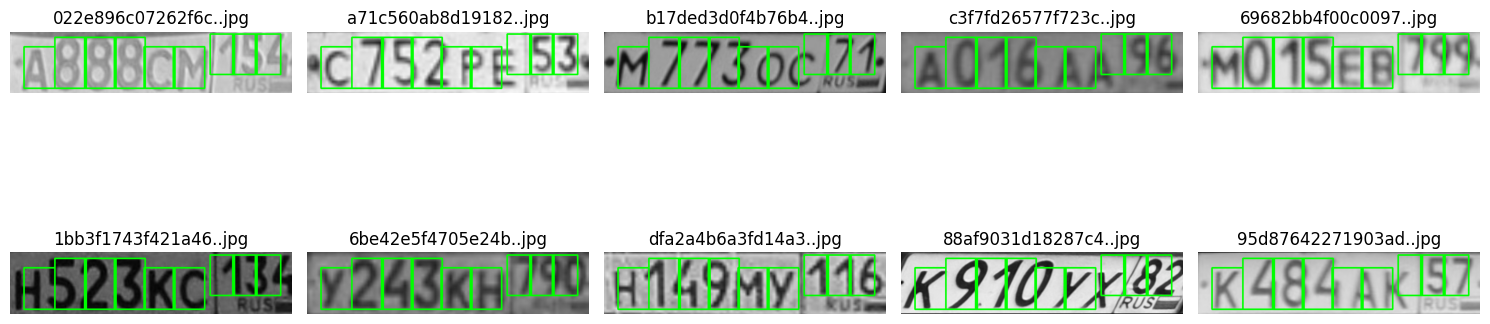

In [40]:
draw('/content/dimage', show_template=True, template = 3)

# Вывод модели

In [41]:
df = pd.read_csv('/content/modelPredict.csv')

Модель делает предсказание разбивая изображение и по шаблону 2 и по шаблону 3.

In [42]:
df

,image_name,prediction_region_length_2,prediction_region_length_3
0,95d87642271903ad,K484AK57,K4841H157
1,69682bb4f00c0097,MTTY1T99,M015EB799
2,dfa2a4b6a3fd14a3,HH5HHT16,HTM9MY116
3,a71c560ab8d19182,C752PE53,C752T1153
4,c3f7fd26577f723c,A016AA96,A0161Y096
5,b17ded3d0f4b76b4,M773OC71,M113CO171
6,1bb3f1743f421a46,H32MCMH4,H523KCM34
7,88af9031d18287c4,P91OY142,492274462
8,022e896c07262f6c,A7221T54,A888CM154
9,6be42e5f4705e24b,Y2430H50,Y243KH790
